In [77]:
!pip install PySastrawi

In [133]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from keras.layers import Dense, Embedding, LSTM, GRU, Conv1D, Concatenate, Bidirectional, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from transformers import TFBertModel

In [79]:
data = pd.read_csv('/kaggle/input/hs-dataset2/re_dataset.csv', encoding='latin-1')
data.drop(['HS_Individual',	'HS_Group',	'HS_Religion','HS_Race','HS_Physical','HS_Gender','HS_Other','HS_Weak','HS_Moderate','HS_Strong'], axis=1, inplace=True)
#One-hot encoding
data['HS_Abusive'] = (data['HS'] & data['Abusive']).astype(int)
data.loc[data['HS_Abusive'] == 1, ['HS', 'Abusive']] = 0
data['Clean'] = (data.iloc[:, 1:] == 0).all(axis=1).astype(int)
data.head(15)

,Tweet,HS,Abusive,HS_Abusive,Clean
0,- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !',0,0,1,0
1,RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga',0,1,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter",0,0,0,1
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU',0,0,0,1
4,USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah',0,0,1,0
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x9f\x98\x84\xf0\x9f\x98\x84',0,0,1,0
6,deklarasi pilkada 2018 aman dan anti hoax warga dukuh sari jabon,0,0,0,1
7,Gue baru aja kelar re-watch Aldnoah Zero!!! paling kampret emang endingnya! 2 karakter utama cowonya kena friendzone bray! XD URL,0,1,0,0
8,"Nah admin belanja satu lagi port terbaik nak makan Ais Kepal Milo, Ais Kepal Horlicks atau Cendol Toping kaw kaw. ð??­; ; Doket mano tu ? Gerai Rojak Mertuaku - Taipan 2 (depan TWINS BABY &amp; ROMANTIKA / Bank Islam Senawang) ð???",0,0,0,1
9,USER Enak lg klo smbil ngewe',0,1,0,0


In [80]:
print(data["Tweet"][26])
print(data.iloc[26])

Ini si USER kerjaannya delay mulu! Setan!'
Tweet         Ini si USER kerjaannya delay mulu! Setan!'
HS                                                     0
Abusive                                                0
HS_Abusive                                             1
Clean                                                  0
Name: 26, dtype: object


In [81]:
data.describe()

,HS,Abusive,HS_Abusive,Clean
count,13169.000000,13169.000000,13169.000000,13169.000000
mean,0.172071,0.132736,0.250209,0.444984
std,0.377456,0.339302,0.433150,0.496983
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet       13169 non-null  object
 1   HS          13169 non-null  int64 
 2   Abusive     13169 non-null  int64 
 3   HS_Abusive  13169 non-null  int64 
 4   Clean       13169 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 514.5+ KB


In [62]:
data.isna().sum()

Tweet         0
HS            0
Abusive       0
HS_Abusive    0
Clean         0
dtype: int64

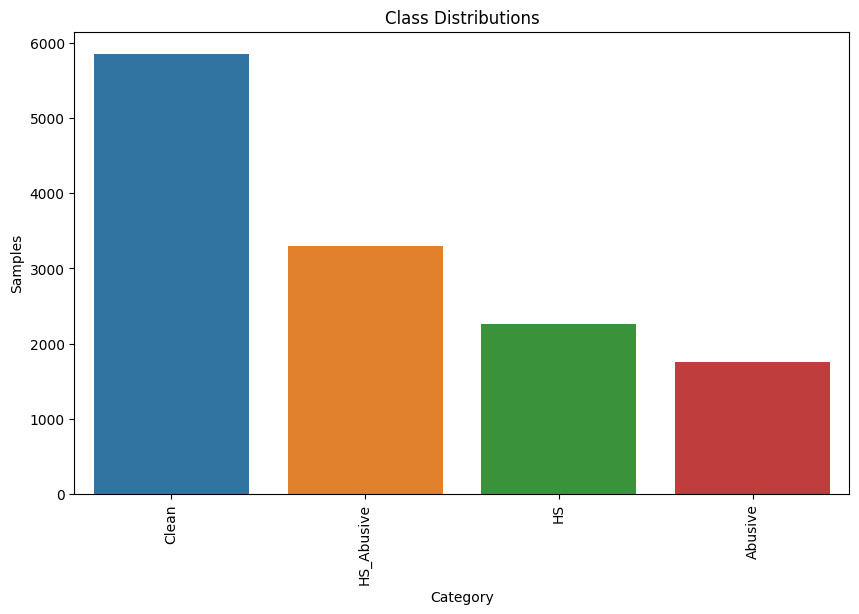

In [83]:
x = data.iloc[:, 1:]  # Ambil semua kolom kecuali kolom pertama yang mungkin merupakan fitur lain

class_distribution = x.sum().sort_values(ascending=False)

# Plot distribusi kelas
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution)
plt.title('Class Distributions')
plt.ylabel('Samples')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

In [64]:
print(class_distribution)

Clean         5860
HS_Abusive    3295
HS            2266
Abusive       1748
dtype: int64


In [84]:
ros = RandomOverSampler(random_state=42)

y_labels = data[['HS','Abusive','HS_Abusive','Clean']]

y_labels_array = y_labels.to_numpy()

X_resampled, y_resampled = ros.fit_resample(data[['Tweet']], y_labels_array)

data = pd.concat([pd.DataFrame(X_resampled, columns=['Tweet']), pd.DataFrame(y_resampled, columns=['HS','Abusive','HS_Abusive','Clean'])], axis=1)

# data['Clean'] = (data.iloc[:, 1:] == 0).all(axis=1).astype(int)
# Output DataFrame setelah oversampling
print(data)


                                                                                                                                                                                                                                                                Tweet  \
0                                                                                                                          - disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'   
1                                                                                                                                            RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'   
2      41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23440 entries, 0 to 23439
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet       23440 non-null  object
 1   HS          23440 non-null  int64 
 2   Abusive     23440 non-null  int64 
 3   HS_Abusive  23440 non-null  int64 
 4   Clean       23440 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 915.8+ KB


In [67]:
data.isna().sum()

Tweet         0
HS            0
Abusive       0
HS_Abusive    0
Clean         0
dtype: int64

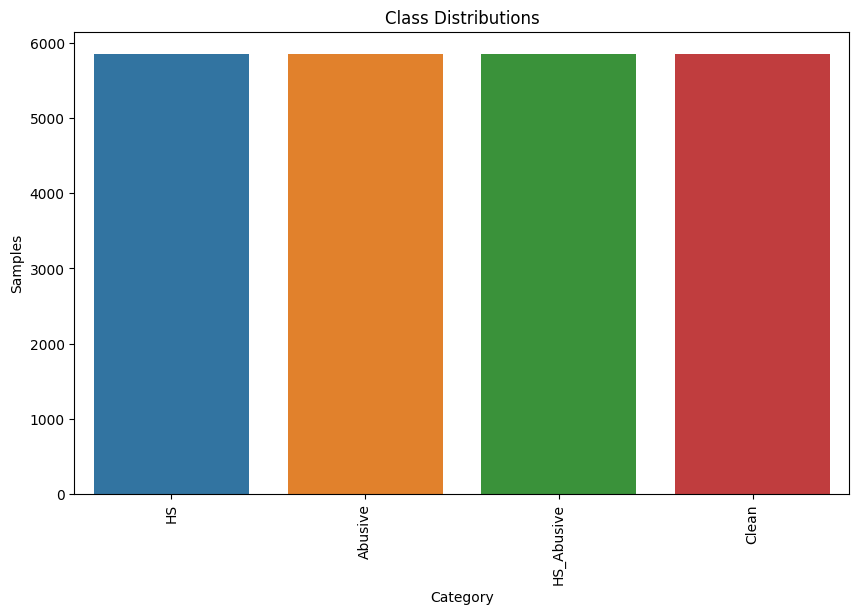

In [86]:
x = data.iloc[:, 1:] 
class_distribution = x.sum().sort_values(ascending=False)

# Plot distribusi kelas
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution)
plt.title('Class Distributions')
plt.ylabel('Samples')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

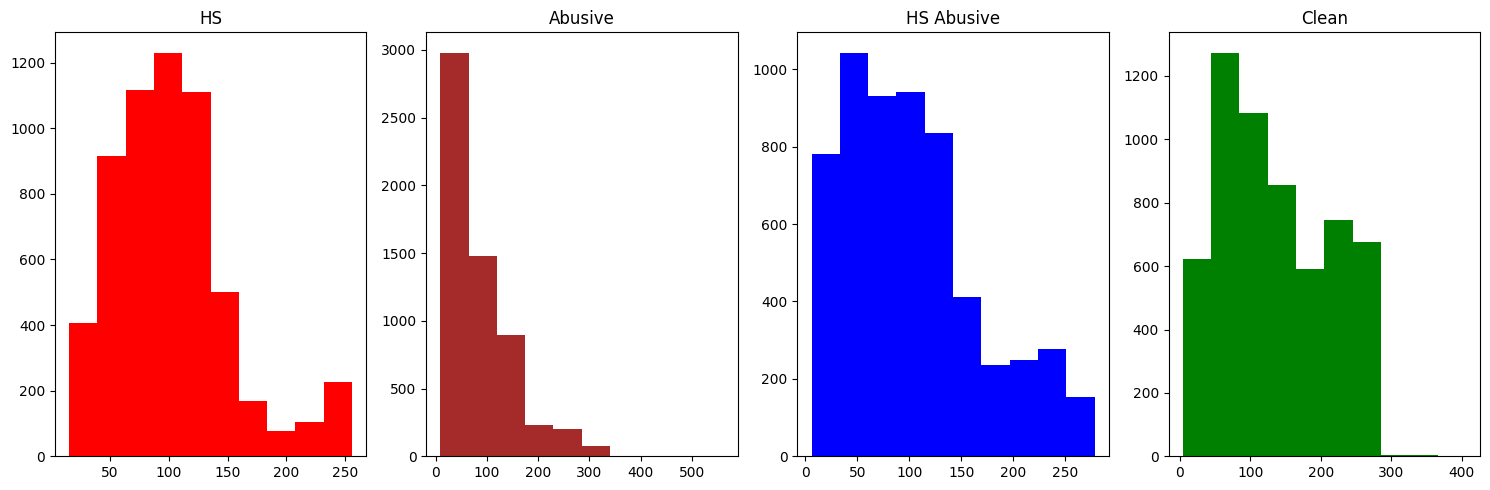

In [87]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Menggunakan 4 subplot untuk 3 kelas berbeda

# Plot untuk kelas HS
count_hs = data[data['HS'] == 1]['Tweet'].str.len()
axes[0].hist(count_hs, color='red')
axes[0].set_title('HS')

count_abus = data[data['Abusive'] == 1]['Tweet'].str.len()
axes[1].hist(count_abus, color='brown')
axes[1].set_title('Abusive')

count_hsabus = data[data['HS_Abusive'] == 1]['Tweet'].str.len()
axes[2].hist(count_hsabus, color='blue')
axes[2].set_title('HS Abusive')

count_clean = data[data['Clean'] == 1]['Tweet'].str.len()
axes[3].hist(count_clean, color='green')
axes[3].set_title('Clean')

plt.tight_layout()
plt.show()

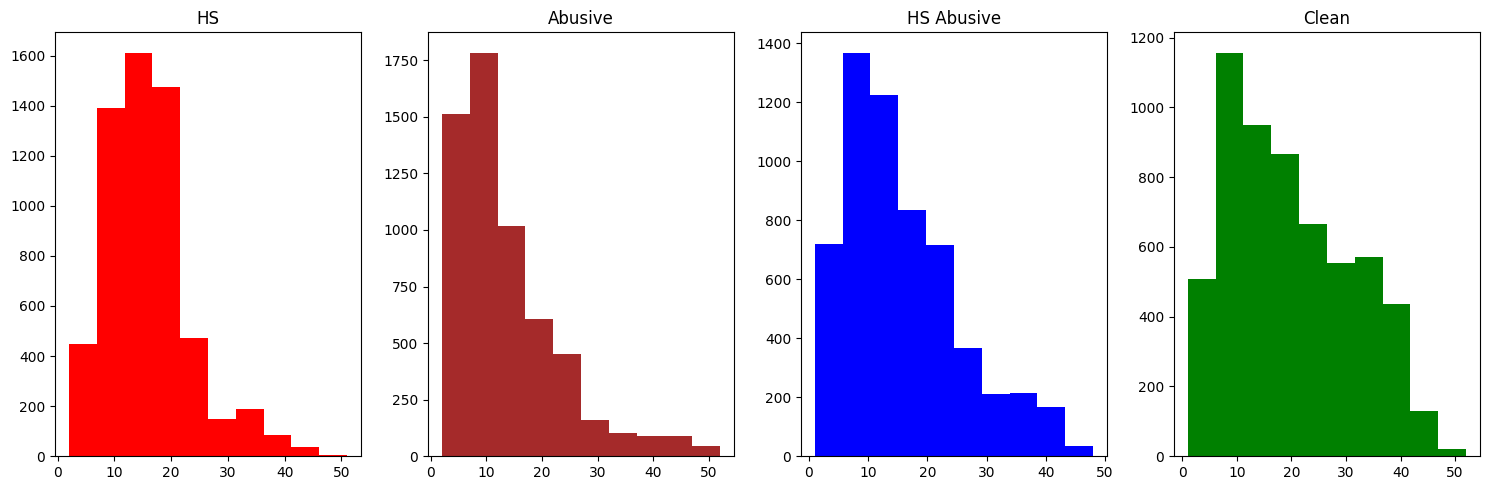

In [88]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Menggunakan 4 subplot untuk 3 kelas berbeda

# Plot untuk kelas HS
count_hs = data[data['HS'] == 1]['Tweet'].str.split().map(lambda x: len(x))
axes[0].hist(count_hs, color='red')
axes[0].set_title('HS')

count_abus = data[data['Abusive'] == 1]['Tweet'].str.split().map(lambda x: len(x))
axes[1].hist(count_abus, color='brown')
axes[1].set_title('Abusive')

count_hsabus = data[data['HS_Abusive'] == 1]['Tweet'].str.split().map(lambda x: len(x))
axes[2].hist(count_hsabus, color='blue')
axes[2].set_title('HS Abusive')

count_clean = data[data['Clean'] == 1]['Tweet'].str.split().map(lambda x: len(x))
axes[3].hist(count_clean, color='green')
axes[3].set_title('Clean')

plt.tight_layout()
plt.show()

In [89]:
nltk.download('stopwords')
stopwords_id = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


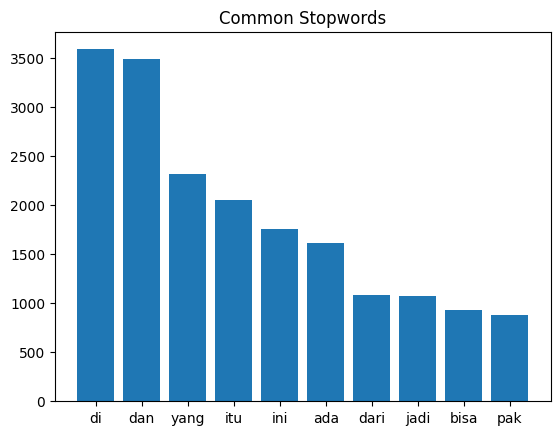

In [90]:
from collections import defaultdict

def create_corpus_one_hot(df):
    corpus = []
    for index, row in df.iterrows():
        for col in ['Tweet', 'HS','HS_Abusive', 'Clean']:
            if row[col] == 1:
                # Menggunakan split untuk mendapatkan setiap kata dari 'Tweet'
                for word in row['Tweet'].split():
                    corpus.append(word.lower())
    return corpus

def common_stopwords_one_hot(df):
    corpus = create_corpus_one_hot(df)
    dict_result = defaultdict(int)
    
    for word in corpus:
        if word in stopwords_id:  # Pastikan stopwords_id sudah didefinisikan sebelumnya
            dict_result[word] += 1

    sorted_dict_result = dict(sorted(dict_result.items(), key=lambda x: x[1], reverse=True)[:10])
    
    plt.bar(sorted_dict_result.keys(), sorted_dict_result.values())
    plt.title('Common Stopwords')
    plt.show()

# Menggunakan fungsi common_stopwords_one_hot untuk DataFrame dengan label kelas one-hot encoded
common_stopwords_one_hot(data)

In [91]:
alayDict = pd.read_csv('/kaggle/input/hs-dataset2/new_kamusalay.csv', encoding='latin-1',header=None)
alayDict = alayDict.rename(columns={0: 'original',
                                      1: 'replacement'})

In [92]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','',text) # Remove every URL
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('\r',' ',text) # Remove every '\r'
    text = re.sub('(?i)rt',' ',text) # Remove every retweet symbol
    text = re.sub('@[^\s]+[ \t]','',text) # Remove every username
    text = re.sub('(?i)user','',text) # Remove every username
    text = re.sub('(?i)url',' ',text) # Remove every url
    text = re.sub(r'\\x..',' ',text) # Remove every emoji
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) #Remove characters repeating more than twice
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alayDictMap = dict(zip(alayDict['original'], alayDict['replacement']))
def normalize_alay(text):
    return ' '.join([alayDictMap[word] if word in alayDictMap else word for word in text.split(' ')])

# def remove_stopword(text):
#     text = ' '.join(['' if word in stopwords_id else word for word in text.split(' ')])
#     text = re.sub('  +', ' ', text) # Remove extra spaces
#     text = text.strip()
#     return text

def remove_stopword(text):
    words = text.split(' ')
    processed_words = []
    for word in words:
        if word.lower() in stopwords_id and word.lower() != 'tidak':
            processed_words.append('')
        else:
            processed_words.append(word)
    text = ' '.join(processed_words)
    text = re.sub('  +', ' ', text)  # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = remove_unnecessary_char(text) # 1
    text = lowercase(text) # 2
    text = remove_nonaplhanumeric(text) # 3
    text = normalize_alay(text) # 4
    text = stemming(text) # 5
#     text = remove_stopword(text) # 6
    text = text.strip()
    return text

In [93]:
t = data['Tweet'][99]
text_p = preprocess(t)
print(t)
print(text_p)

Ha .. ha .. Banyak baca biar pintar ... JEPANG, AMERIKA, CHINA... Utang sama siapa ... Anda tau enggak ..?
apa apa banyak baca biar pintar jepang amerika cina utang sama siapa anda tau tidak


In [94]:
data['Tweet'] = data['Tweet'].apply(preprocess)

In [95]:
data.tail(23)

,Tweet,HS,Abusive,HS_Abusive,Clean
23417,maju kamu sini anjing gue mau tampar lo berengsek,0,0,1,0
23418,sih dakwa nista agama alias sih ahok babi jamban itu yang morfin uang rakyat jaka a,0,0,1,0
23419,kejar setor ke cina belum pak djarot lengser rezim jongos cina sangat bahaya bangsa negara hukum undang undang dan konstitusi labrak,0,0,1,0
23420,kok kapan punya kader begini waduh ini sih sudah pak ai bejat nama malu,0,0,1,0
23421,1 kata buat kamu bajing,0,0,1,0
23422,wkwk iya itu gara gara sih andri fals bangkai sih provokator,0,0,1,0
23423,manis cuma di awal butut goblok soler out herjos out,0,0,1,0
23424,jimin beri link dasar manusia homo jin lama kamu bagi apa kamu kata gue mau sama dia idih ogah non rebreathing mask gue masih suka cewek buru hapus,0,0,1,0
23425,itu sih ahok kutil babi,0,0,1,0
23426,pergi kamu bangkai,0,0,1,0


In [111]:
teks = data['Tweet'].values
label = data[['HS','Abusive','HS_Abusive','Clean']].values

In [112]:
teks_latih, teks_test, label_latih, label_test = train_test_split(teks, label, test_size=0.2)

In [ ]:
teks_latih

In [113]:
tokenizer = Tokenizer(num_words=13000, oov_token='<oov>')

tokenizer.fit_on_texts(teks_latih)
tokenizer.fit_on_texts(teks_test)

sekuens_latih = tokenizer.texts_to_sequences(teks_latih)
sekuens_test = tokenizer.texts_to_sequences(teks_test)

padded_latih = pad_sequences(sekuens_latih, maxlen=50,padding='post',truncating='post')
padded_test = pad_sequences(sekuens_test, maxlen=50,padding='post',truncating='post')

In [99]:
from gensim.models import FastText
from keras.preprocessing.text import Tokenizer
import numpy as np

# Get the size of the vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Train FastText model
fasttext_model = FastText(sentences=[text.split() for text in data['Tweet']], vector_size=256, window=6, min_count=1, workers=4)

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, 256))

# Populate embedding matrix with FastText vectors
for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

print(embedding_matrix)


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0035287  -0.00076789 -0.00114637 ... -0.00421315 -0.00645416
   0.0017139 ]
 [-0.04076526 -0.55309325  0.74494988 ...  0.10840525 -0.64985931
  -0.25033218]
 ...
 [-0.05531846  0.07327701  0.09118779 ... -0.22528455 -0.23411164
   0.01940425]
 [-0.06879281  0.05193087  0.1239801  ... -0.16152449 -0.14082636
  -0.01225412]
 [-0.06518706  0.05940231 -0.05215219 ... -0.16432652 -0.24051559
   0.04871056]]


In [114]:
vocab_size = len(tokenizer.word_index) + 1

word2vec_model = Word2Vec(sentences=[text.split() for text in data['Tweet']], vector_size=256, window=6, min_count=1, workers=4)


embedding_matrix = np.zeros((vocab_size, 256))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
        
print(embedding_matrix)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.08655885e-01 -7.97197640e-01 -1.40066311e-01 ... -4.31040287e-01
  -3.53559703e-01 -3.45937073e-01]
 ...
 [ 2.90913740e-05 -3.97284376e-03  1.55312510e-03 ... -2.21692654e-03
  -5.37186395e-03 -3.61813029e-04]
 [ 3.23536544e-04 -8.41943920e-03  1.96759845e-03 ...  1.96695724e-03
  -9.37138684e-04 -2.22316664e-03]
 [-4.12702002e-03 -6.33856095e-03  2.74023646e-03 ... -9.58408788e-03
  -6.47491822e-03 -4.24329238e-03]]


In [122]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(weights=[embedding_matrix],input_dim=vocab_size, output_dim=256),
#     Bidirectional(LSTM(32, activation='sigmoid', return_sequences=True)),
    LSTM(64, activation='sigmoid', return_sequences=True),
    GlobalMaxPooling1D(),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(45, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
# plot_model(model, to_file='/kaggle/working/model_flowchart.png', show_shapes=True, show_layer_names=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 256)         3303168   
                                                                 
 lstm_8 (LSTM)               (None, None, 64)          82176     
                                                                 
 global_max_pooling1d_8 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_16 (Dense)            (None, 45)                2925      
                                                                 
 dropout_16 (Dropout)        (None, 45)                0         
                                                                 
 batch_normalization_8 (Bat  (None, 45)                180       
 chNormalization)                                     

In [135]:
model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=256, weights=[embedding_matrix]),
    LSTM(32, activation='sigmoid', return_sequences=True),
    GRU(32, activation='sigmoid', return_sequences=True),  # Added GRU layer
    Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(45, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
# plot_model(model, to_file='/kaggle/working/model_flowchart.png', show_shapes=True, show_layer_names=False)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 256)         3303168   
                                                                 
 lstm_13 (LSTM)              (None, None, 32)          36992     
                                                                 
 gru_4 (GRU)                 (None, None, 32)          6336      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          3104      
                                                                 
 global_max_pooling1d_12 (G  (None, 32)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_24 (Dense)            (None, 45)                1485      
                                                      

In [136]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
best_model = ModelCheckpoint('/kaggle/working/bestmodel.hdf5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [137]:
num_epochs = 30
batch = 32
# Menghitung jumlah sampel positif untuk setiap label
pos_label_counts = label_latih.sum(axis=0)

# Menghitung jumlah total sampel
total_samples = len(label_latih)

# Menghitung class weights untuk setiap label
class_weights = {}
for i, count in enumerate(pos_label_counts):
    class_weights[i] = total_samples / (len(np.unique(label_latih[:, i])) * count)
    
history = model.fit(padded_latih,
                    label_latih,
                    epochs=num_epochs,
                    batch_size = batch,
                    class_weight=class_weights,
                    validation_data=(padded_test, label_test),
                    verbose=1,
                    callbacks =[best_model, early_stopping_monitor,reduce_lr])

Epoch 1/30
586/586 [==============================] - 76s 124ms/step - loss: 2.2706 - accuracy: 0.4573 - val_loss: 0.8408 - val_accuracy: 0.6237 - lr: 0.0010
Epoch 2/30
586/586 [==============================] - 54s 92ms/step - loss: 1.5588 - accuracy: 0.6702 - val_loss: 0.6663 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 3/30
586/586 [==============================] - 52s 90ms/step - loss: 1.2234 - accuracy: 0.7665 - val_loss: 0.5855 - val_accuracy: 0.7809 - lr: 0.0010
Epoch 4/30
586/586 [==============================] - 51s 88ms/step - loss: 0.9827 - accuracy: 0.8270 - val_loss: 0.5174 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 5/30
586/586 [==============================] - 52s 89ms/step - loss: 0.7717 - accuracy: 0.8703 - val_loss: 0.4692 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 6/30
586/586 [==============================] - 52s 89ms/step - loss: 0.6284 - accuracy: 0.8955 - val_loss: 0.4512 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 7/30
586/586 [==============================] - 51s

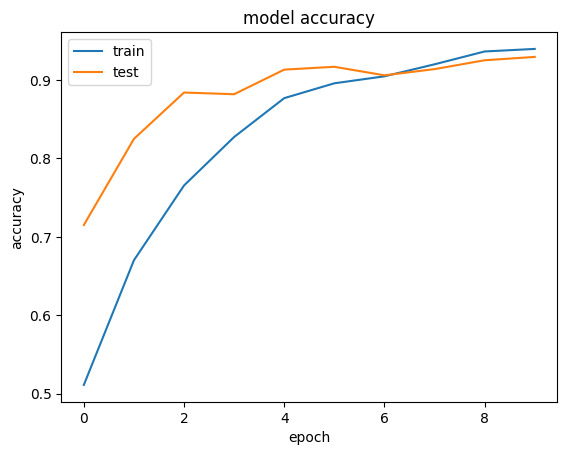

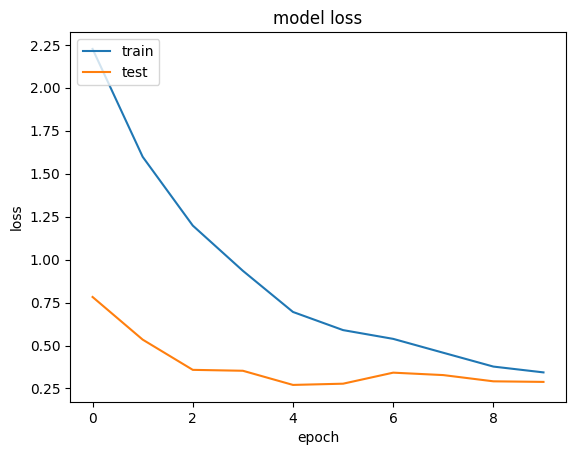

In [117]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
# Lakukan prediksi menggunakan model Sequential pada data uji
y_pred_prob = model.predict(padded_test)

# Ambil indeks kelas dengan probabilitas tertinggi untuk setiap sampel
y_pred = np.argmax(y_pred_prob, axis=1)

# Ubah label yang terprediksi menjadi format yang sesuai
y_true = np.argmax(label_test, axis=1)

# Cetak laporan klasifikasi
print(classification_report(y_true, y_pred))

147/147 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1124
           1       0.92      0.94      0.93      1173
           2       0.90      0.92      0.91      1138
           3       0.92      0.86      0.89      1253

    accuracy                           0.91      4688
   macro avg       0.91      0.91      0.91      4688
weighted avg       0.91      0.91      0.91      4688



In [ ]:
joblib.dump(tokenizer,'/kaggle/working/tokenizer.joblib')

In [ ]:
tokenizer2 = joblib.load('/kaggle/working/tokenizer.joblib')
model2 = tf.keras.models.load_model('/kaggle/working/bestmodel.hdf5')
def tes(index):
  return print(label_test[index], teks_test[index])
def prediksi(text):
#   tokenizer.fit_on_texts(text)
  text_sekuens = tokenizer2.texts_to_sequences(text)
  text_padded = pad_sequences(text_sekuens, maxlen=900,padding='post',truncating='post')
  return text_padded

In [ ]:
index = 1863
tes(index)
result = model2.predict(prediksi([teks_test[index]]))
print(result)
print(np.argmax(result))

if(np.argmax(result) == 0):
    print("hate speech")
elif(np.argmax(result)==1):
    print("abusive")
elif(np.argmax(result) == 2):
    print("hate speech & abusive")
else:
    print("clean")

